In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
#This is shit check how to import well
sys.path.insert(1, '/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering/Code/utilities')
import cwt , clusters
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn.cluster import KMeans

In [4]:
transform = torch.load("../Data/synthetic-data/train-DAS/CWT-edDAS/transform0000_window1.pt")
features = np.array(transform)
features = np.reshape(features, (features.shape[0] * features.shape[1], -1))
print(features.shape)

(1536000, 63)


In [5]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, encoding_dim)
        )
        ## decoder ##
        self.decoder =   self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.Tanh(),
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32,input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        if(not torch.is_tensor(x)):
            x = torch.tensor(x, dtype=torch.float32)
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        # pass x into encoder
        out = F.relu(self.encoder(x))
        # pass out into decoder
        out = self.decoder(out)
        
        return out
    
    def encode(self, x ):
        if(not torch.is_tensor(x)):
            x = torch.tensor(x, dtype=torch.float32)
        return self.encoder(x)

# initialize the NN
encoding_dim = 6

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=63, out_features=32, bias=True)
    (1): ReLU()
    (2): Tanh()
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): Tanh()
    (5): Linear(in_features=16, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=63, bias=True)
    (5): Sigmoid()
  )
)


In [27]:
model = Autoencoder(encoding_dim, features.shape[1])
batch_size = 1000
batched_data = torch.tensor(np.reshape(features, (batch_size, -1, features.shape[1])))
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 50
losses = np.zeros(n_epochs)

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in batched_data:
        images = torch.tensor(data, dtype=torch.float32)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(batched_data)
    losses[epoch-1] = train_loss
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_2823/1138570089.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(data, dtype=torch.float32)


Epoch: 1 	Training Loss: 330.486478
Epoch: 2 	Training Loss: 301.966927
Epoch: 3 	Training Loss: 293.887351
Epoch: 4 	Training Loss: 287.625566
Epoch: 5 	Training Loss: 280.095159
Epoch: 6 	Training Loss: 275.511570
Epoch: 7 	Training Loss: 272.690594
Epoch: 8 	Training Loss: 268.132393
Epoch: 9 	Training Loss: 265.758187
Epoch: 10 	Training Loss: 263.990861
Epoch: 11 	Training Loss: 261.805708
Epoch: 12 	Training Loss: 260.546002
Epoch: 13 	Training Loss: 259.680250
Epoch: 14 	Training Loss: 259.099019
Epoch: 15 	Training Loss: 258.616759
Epoch: 16 	Training Loss: 258.197523
Epoch: 17 	Training Loss: 257.825074
Epoch: 18 	Training Loss: 257.440825
Epoch: 19 	Training Loss: 256.899606
Epoch: 20 	Training Loss: 256.338478
Epoch: 21 	Training Loss: 255.994176
Epoch: 22 	Training Loss: 255.714029
Epoch: 23 	Training Loss: 255.469689
Epoch: 24 	Training Loss: 255.268276
Epoch: 25 	Training Loss: 255.098675
Epoch: 26 	Training Loss: 254.956155
Epoch: 27 	Training Loss: 254.838854
Epoch: 28 

Text(0.5, 1.0, 'Training Loss ')

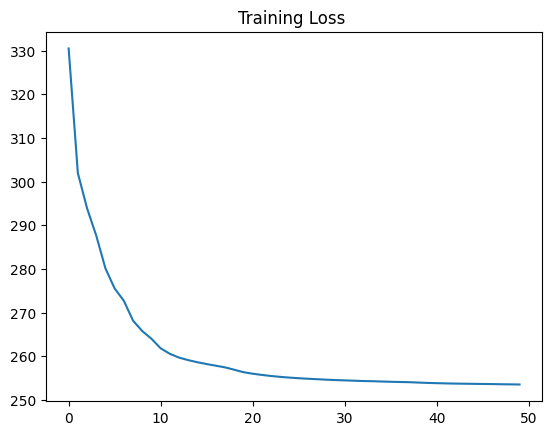

In [28]:
plt.plot(losses)
plt.title("Training Loss ")

torch.Size([512, 3000, 63])


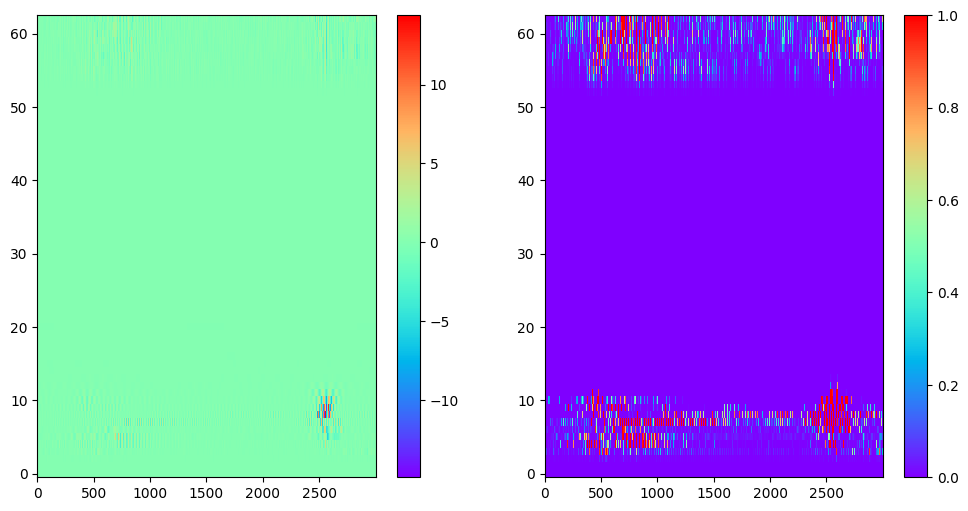

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(12,6))
print(transform.shape)
reconstruction = model(transform[0])
img1 = ax1.imshow(transform[0].T, origin='lower', interpolation='nearest', cmap='rainbow', aspect='auto')
img2 = ax2.imshow(reconstruction.detach().numpy().T, origin='lower', interpolation='nearest', cmap='rainbow', aspect='auto')
fig.colorbar(img1, ax=ax1)
fig.colorbar(img2 , ax =ax2)